<a href="https://colab.research.google.com/github/fraco03/6D_pose/blob/ResNet/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: SETUP AND DATA DOWNLOAD
import os

# 1. Define Paths
# Ensure the data goes into the correct directory structure
project_root = '/content/6D_pose'
data_dir = os.path.join(project_root, 'data')
os.makedirs(data_dir, exist_ok=True)

# 2. Move to data directory
%cd {data_dir}

# 3. Download the dataset folder from Google Drive
!pip install gdown -q
print("Downloading folder from Drive...")
# Downloads the folder structure containing the Linemod dataset
!gdown --folder "https://drive.google.com/drive/folders/19ivHpaKm9dOrr12fzC8IDFczWRPFxho7" --remaining-ok

# 4. Find and Unzip the Linemod dataset
# The download creates a folder (usually named 'DenseFusion')
# Search for 'Linemod_preprocessed.zip' recursively and extract it
import glob
zip_files = glob.glob("**/Linemod_preprocessed.zip", recursive=True)

if zip_files:
    zip_path = zip_files[0]
    print(f"Unzipping {zip_path}...")
    !unzip -q -o "{zip_path}"
    print("Extraction complete!")
else:
    print("Error: Linemod_preprocessed.zip not found. Check the download.")

# 5. Return to Project Root
%cd {project_root}

/content/6D_pose/data
Retrieving folder contents
Processing file 1YFUra533pxS_IHsb9tB87lLoxbcHYXt8 Linemod_preprocessed.zip
Processing file 1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6 trained_checkpoints.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1YFUra533pxS_IHsb9tB87lLoxbcHYXt8
From (redirected): https://drive.google.com/uc?id=1YFUra533pxS_IHsb9tB87lLoxbcHYXt8&confirm=t&uuid=acf51e7d-424d-4cba-803d-f6f8864549c0
To: /content/6D_pose/data/DenseFusion/Linemod_preprocessed.zip
100% 8.97G/8.97G [02:50<00:00, 52.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6
From (redirected): https://drive.google.com/uc?id=1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6&confirm=t&uuid=59228aa8-eb30-4fa5-b318-9c71407ec98c
To: /content/6D_pose/data/DenseFusion/trained_checkpoints.zip
100% 253M/253M [00:03<00:00, 82.6MB/s]
Download completed
Unzippi

In [ ]:
%cd ./src/pose_rgb

/content/6D_pose/src/pose_rgb


In [ ]:
%pwd

'/content/6D_pose/src/pose_rgb'

In [ ]:
import os
import cv2
import numpy as np
import yaml
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, List, Tuple, Optional

import numpy as np

def convert_rotation_to_quaternion(rotation_matrix: np.ndarray) -> np.ndarray:
    """Convert a rotation matrix to a quaternion representation"""

    assert rotation_matrix.shape == (3, 3), "Input must be a 3x3 rotation matrix."

    m = rotation_matrix
    trace = np.trace(m)

    if trace > 0:
        s = 0.5 / np.sqrt(trace + 1.0)
        w = 0.25 / s
        x = (m[2, 1] - m[1, 2]) * s
        y = (m[0, 2] - m[2, 0]) * s
        z = (m[1, 0] - m[0, 1]) * s
    else:
        if m[0, 0] > m[1, 1] and m[0, 0] > m[2, 2]:
            s = 2.0 * np.sqrt(1.0 + m[0, 0] - trace)
            w = (m[2, 1] - m[1, 2]) / s
            x = 0.25 * s
            y = (m[0, 1] + m[1, 0]) / s
            z = (m[0, 2] + m[2, 0]) / s
        elif m[1, 1] > m[2, 2]:
            s = 2.0 * np.sqrt(1.0 + m[1, 1] - trace)
            w = (m[0, 2] - m[2, 0]) / s
            x = (m[0, 1] + m[1, 0]) / s
            y = 0.25 * s
            z = (m[1, 2] + m[2, 1]) / s
        else:
            s = 2.0 * np.sqrt(1.0 + m[2, 2] - trace)
            w = (m[1, 0] - m[0, 1]) / s
            x = (m[0, 2] + m[2, 0]) / s
            y = (m[1, 2] + m[2, 1]) / s
            z = 0.25 * s

    quaternion = np.array([w, x, y, z])
    quaternion /= (np.linalg.norm(quaternion) + 1e-8)  # Normalize the quaternion
    return quaternion

def quaternion_to_rotation_matrix(quaternion: np.ndarray) -> np.ndarray:
    """Convert a quaternion to a rotation matrix representation"""

    assert quaternion.shape == (4,), "Input must be a quaternion of shape (4,)."

    w, x, y, z = quaternion
    R = np.array([
        [1 - 2*(y**2 + z**2), 2*(x*y - z*w),     2*(x*z + y*w)],
        [2*(x*y + z*w),     1 - 2*(x**2 + z**2), 2*(y*z - x*w)],
        [2*(x*z - y*w),     2*(y*z + x*w),     1 - 2*(x**2 + y**2)]
    ])
    return R


class LineModPoseDataset(Dataset):
    """
    LineMod Dataset for 6D Pose Estimation

    Returns cropped object images and corresponding poses.
    """

    VALID_OBJECTS = [
        1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15
    ]  # object id 3, 7 not available

    CLASS_NAMES = [
        'ape', 'benchvise', 'camera', 'can', 'cat',
        'driller', 'duck', 'eggbox', 'glue', 'holepuncher',
        'iron', 'lamp', 'phone'
    ]

    def __init__(
        self,
        root_dir: str,
        split: str = 'train',
        object_ids: Optional[List[int]] = None,
        image_size: Tuple[int, int] = (224, 224),
        transform = None,
        normalize: bool = True
    ):
        """
        Args:
            root_dir (str): Path to the LineMod preprocessed dataset.
            split (str): 'train' or 'test' split.
            object_ids (List[int], optional): List of object IDs to include. If None, include all.
            image_size (Tuple[int, int]): Size to which images are resized.
            transform: Optional transform to be applied on a sample.
            normalize (bool): Whether to imagenet normalization.
        """

        self.root_dir = Path(root_dir)
        self.data_dir = self.root_dir / 'data'
        self.split = split
        self.image_size = image_size
        self.transform = transform
        self.normalize = normalize

        self.object_ids = object_ids if object_ids is not None else self.VALID_OBJECTS

        self.id_to_class = {obj_id: self.CLASS_NAMES[i] for i, obj_id in enumerate(self.VALID_OBJECTS)}

        self.samples = self._build_index()

        print(f" Loaded LineModPoseDataset")
        print(f"   Split: {self.split}")
        print(f"   Objects: {self.object_ids}")
        print(f"   Total samples: {len(self.samples)}")

    def _build_index(self) -> List[Dict]:
        samples = []

        for obj_id in self.object_ids:
            obj_folder = f"{obj_id:02d}"
            obj_path = self.data_dir / obj_folder

            split_file = obj_path / f"{self.split}.txt"

            if not split_file.exists():
                print(f"Warning: Split file {split_file} does not exist.")
                continue

            with open(split_file, 'r') as f:
                img_ids = [int(line.strip()) for line in f.readlines()]  # Image IDs for this split

            # Ground truth information (including poses)
            gt_file = obj_path / "gt.yml"
            with open(gt_file, 'r') as f:
                gt_data = yaml.safe_load(f)

            # Camera intrinsics file
            info_file = obj_path / "info.yml"
            with open(info_file, 'r') as f:
                info_data = yaml.safe_load(f)

            # Load samples
            for img_id in img_ids:
                if img_id not in gt_data:
                    continue  # Skip if no GT data for this image

                img_path = obj_path / 'rgb' / f"{img_id:04d}.png"

                if not img_path.exists():
                    continue  # Skip if image does not exist

                annotations = gt_data[img_id]
                for ann in annotations:
                    if int(ann['obj_id']) != obj_id:
                        continue  # Skip if not the current object

                    rotation_matrix = np.array(ann['cam_R_m2c']).reshape(3, 3)
                    translation_vector = np.array(ann['cam_t_m2c'])
                    quaternion_rotation = convert_rotation_to_quaternion(rotation_matrix)

                    sample = {
                        'object_id': obj_id,
                        'class_idx': self.id_to_class[obj_id],
                        'img_id': img_id,
                        'img_path': obj_path / 'rgb' / f"{img_id:04d}.png",
                        'rotation': quaternion_rotation,
                        'translation': translation_vector,
                        'bbox': ann['obj_bb'],  # [x, y, w, h]
                        'cam_K': np.array(info_data[img_id]['cam_K']).reshape(3, 3)
                    }

                    samples.append(sample)

                    break  # Only one annotation per object per image
        return samples

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> Dict:
        sample = self.samples[idx]

        # Load image
        img = cv2.imread(str(sample['img_path']))
        if img is None:  # Handle case where image file might be corrupted or missing
            print(f"Warning: Could not load image from {sample['img_path']}. Returning black image.")
            cropped_img = np.zeros((self.image_size[1], self.image_size[0], 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Crop using bounding box
            x, y, w, h = map(int, sample['bbox'])

            # Ensure valid bounding box coordinates and dimensions are within image bounds
            img_height, img_width = img.shape[0], img.shape[1]

            x_start = max(0, x)
            y_start = max(0, y)
            x_end = min(img_width, x + w)
            y_end = min(img_height, y + h)

            if x_end > x_start and y_end > y_start:
                cropped_img = img[y_start:y_end, x_start:x_end]
            else:
                print(f"Warning: Invalid or out-of-bounds bbox [{x},{y},{w},{h}] for img_id {sample['img_id']}, obj_id {sample['object_id']}. Image shape: {img.shape}. Creating black image.")
                cropped_img = np.zeros((self.image_size[1], self.image_size[0], 3), dtype=np.uint8)

            # Ensure the cropped image is not empty after slicing (can still happen if slice results in empty array)
            if cropped_img.shape[0] == 0 or cropped_img.shape[1] == 0:
                print(f"Warning: Cropped image is empty after slicing for img_id {sample['img_id']}, obj_id {sample['object_id']}. Creating black image.")
                cropped_img = np.zeros((self.image_size[1], self.image_size[0], 3), dtype=np.uint8)

            # Resize to desired size
            cropped_img = cv2.resize(cropped_img, self.image_size)

        if self.normalize:
            # Standard ImageNet normalization
            cropped_img = cropped_img.astype(np.float32) / 255.0
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            cropped_img = (cropped_img - mean) / std

        if self.transform:
            cropped_img = self.transform(cropped_img)

        # From (H, W, 3) to (3, H, W)
        crop_tensor = torch.from_numpy(cropped_img).permute(2, 0, 1).float()

        return {
            'image': crop_tensor,                                               # (3, 224, 224)
            'rotation': torch.from_numpy(sample['rotation']).float(),           # (4,) [w,x,y,z]
            'translation': torch.from_numpy(sample['translation']).float(),     # (3,)
            'object_id': sample['object_id'],                                   # int
            'class_idx': sample['class_idx'],                                   # int
            'cam_K': torch.from_numpy(sample['cam_K']).float(),                 # (3, 3)
            'img_id': sample['img_id']                                          # int
        }

    def get_class_name(self, class_idx: int) -> str:
        """Get class name from class index"""
        return self.id_to_class.get(class_idx, "Unknown")

In [ ]:
import pathlib

In [ ]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
import torchvision

class ResNetQuaternion(nn.Module):
    """
    ResNet-based 6D Pose Estimation Network

    Predicts:
    - Rotation as quaternion (4 values: w, x, y, z)
    - Translation as 3D vector (tx, ty, tz)

    Uses camera intrinsics (cam_K) to improve translation estimation.
    """

    def __init__(self, freeze_backbone: bool = True):
        """
        Args:
            freeze_backbone: If True, freeze ResNet backbone weights
        """
        super(ResNetQuaternion, self).__init__()

        # ResNet backbone
        resnet = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        feat_dim = resnet.fc.in_features  # 2048 for ResNet50

        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False

        # Camera intrinsics processing
        # Process cam_K: extract fx, fy, cx, cy (4 values)
        self.camera_fc = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU()
        )

        # Fusion layer: combine image features + camera features
        self.fusion = nn.Sequential(
            nn.Linear(feat_dim + 128, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        fused_dim = 512

        # Rotation head (quaternion)
        self.fc_rot = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 4)
        )

        # Translation head
        self.fc_trans = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 3)
        )

    def forward(self, x, cam_K):
        """
        Forward pass

        Args:
            x: (B, 3, 224, 224) RGB image crops
            cam_K: (B, 3, 3) camera intrinsic matrices

        Returns:
            rot: (B, 4) normalized quaternion [w, x, y, z]
            trans: (B, 3) translation vector [tx, ty, tz]
        """
        # Extract image features
        img_feat = self.features(x)  # (B, 2048, 1, 1)
        img_feat = torch.flatten(img_feat, 1)  # (B, 2048)

        # Extract key camera parameters
        # cam_K = [[fx,  0, cx],
        #          [ 0, fy, cy],
        #          [ 0,  0,  1]]
        fx = cam_K[:, 0, 0]  # (B,)
        fy = cam_K[:, 1, 1]  # (B,)
        cx = cam_K[:, 0, 2]  # (B,)
        cy = cam_K[:, 1, 2]  # (B,)

        cam_params = torch.stack([fx, fy, cx, cy], dim=1)  # (B, 4)
        cam_feat = self.camera_fc(cam_params)  # (B, 128)

        # Fuse image and camera features
        combined = torch.cat([img_feat, cam_feat], dim=1)  # (B, 2176)
        fused = self.fusion(combined)  # (B, 512)

        # Predict rotation (quaternion)
        rot = self.fc_rot(fused)  # (B, 4)
        rot = F.normalize(rot, p=2, dim=1)  # Normalize to unit quaternion

        # Predict translation
        trans = self.fc_trans(fused)  # (B, 3)

        return rot, trans

In [ ]:
base_path = pathlib.Path(pathlib.Path.cwd()).parent.parent
root_dir = base_path / 'data'/ 'Linemod_preprocessed'

train_dataset = LineModPoseDataset(split='train', root_dir=root_dir)
test_dataset = LineModPoseDataset(split='test', root_dir=root_dir)

#Dataloder
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

 Loaded LineModPoseDataset
   Split: train
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 2373
 Loaded LineModPoseDataset
   Split: test
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 13407


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class QuaternionLoss(nn.Module):
    """
    Geodesic distance for quaternions

    Measures the angular difference between two rotations.
    More accurate than MSE for quaternions.

    Reference: "On the Continuity of Rotation Representations in Neural Networks" (Zhou et al., CVPR 2019)
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        """
        Args:
            pred: (B, 4) predicted quaternions (normalized)
            target: (B, 4) target quaternions (normalized)

        Returns:
            loss: scalar, geodesic distance
        """
        # Compute dot product (cosine of angle between quaternions)
        # Both quaternions should be normalized
        dot = torch.sum(pred * target, dim=1)

        # Take absolute value (q and -q represent same rotation)
        dot = torch.abs(dot)

        # Clamp to avoid numerical issues with arccos
        dot = torch.clamp(dot, -1.0, 1.0)

        # Geodesic distance: arccos(|<q1, q2>|)
        # Multiply by 2 to get angle in radians
        angle = 2 * torch.acos(dot)

        return angle.mean()


class PoseLoss(nn.Module):
    """
    Combined loss for 6D pose estimation (rotation + translation)

    Properly balances rotation and translation losses which have different scales.

    Args:
        rot_weight: Weight for rotation loss (default: 1.0)
        trans_weight: Weight for translation loss (default: 0.01)
        use_geodesic: Use geodesic distance for quaternions (recommended)
    """
    def __init__(self, rot_weight=1.0, trans_weight=0.01, use_geodesic=True):
        super().__init__()
        self.rot_weight = rot_weight
        self.trans_weight = trans_weight
        self.use_geodesic = use_geodesic

        if use_geodesic:
            self.rot_loss_fn = QuaternionLoss()
        else:
            self.rot_loss_fn = nn.MSELoss()

        self.trans_loss_fn = nn.SmoothL1Loss()  # More robust to outliers than MSE

    def forward(self, pred_rot, pred_trans, gt_rot, gt_trans):
        """
        Args:
            pred_rot: (B, 4) predicted quaternions
            pred_trans: (B, 3) predicted translation (in meters)
            gt_rot: (B, 4) ground truth quaternions
            gt_trans: (B, 3) ground truth translation (in meters)

        Returns:
            total_loss: weighted combination
            rot_loss: rotation loss component
            trans_loss: translation loss component
        """
        # Rotation loss
        if self.use_geodesic:
            rot_loss = self.rot_loss_fn(pred_rot, gt_rot)
        else:
            rot_loss = self.rot_loss_fn(pred_rot, gt_rot)

        # Translation loss (in millimeters for better scale)
        # LineMod translation is in mm, so we keep it as is
        trans_loss = self.trans_loss_fn(pred_trans, gt_trans)

        # Combined loss
        total_loss = self.rot_weight * rot_loss + self.trans_weight * trans_loss

        return total_loss, rot_loss, trans_loss



In [ ]:
from torch import nn, optim
import torch
from tqdm import tqdm
import numpy as np
import os
from datetime import datetime

# Model and optimizer
model = ResNetQuaternion()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modern loss function with proper scaling
criterion = PoseLoss(
    rot_weight=1.0,        # Rotation in radians (0-π scale)
    trans_weight=0.01,     # Translation in mm (0-1000 scale) → need lower weight
    use_geodesic=True      # Use geodesic distance for quaternions
)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")
print(f"Loss function: PoseLoss (geodesic rotation + smooth L1 translation)")
print(f"  Rotation weight: {criterion.rot_weight}")
print(f"  Translation weight: {criterion.trans_weight}")

# Create checkpoint directory
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = f'resnet_pose_{timestamp}'
run_dir = os.path.join(checkpoint_dir, run_name)
os.makedirs(run_dir, exist_ok=True)

print(f"\nSaving checkpoints to: {run_dir}")

# Training configuration
num_epochs = 50
best_val_loss = float('inf')
best_epoch = 0
patience = 10
patience_counter = 0

# Loss tracking (separate rotation and translation)
train_losses = []
val_losses = []
train_rot_losses = []
train_trans_losses = []
val_rot_losses = []
val_trans_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss_epoch = 0.0
    train_rot_epoch = 0.0
    train_trans_epoch = 0.0
    train_batches = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images = batch['image'].to(device)
        cam_K = batch['cam_K'].to(device)
        gt_rot = batch['rotation'].to(device)
        gt_trans = batch['translation'].to(device)

        optimizer.zero_grad()

        # Forward pass
        pred_rot, pred_trans = model(images, cam_K)

        # Compute loss (returns total, rot, trans separately)
        total_loss, rot_loss, trans_loss = criterion(pred_rot, pred_trans, gt_rot, gt_trans)

        # Backward pass
        total_loss.backward()
        optimizer.step()

        train_loss_epoch += total_loss.item()
        train_rot_epoch += rot_loss.item()
        train_trans_epoch += trans_loss.item()
        train_batches += 1

    avg_train_loss = train_loss_epoch / train_batches
    avg_train_rot = train_rot_epoch / train_batches
    avg_train_trans = train_trans_epoch / train_batches

    train_losses.append(avg_train_loss)
    train_rot_losses.append(avg_train_rot)
    train_trans_losses.append(avg_train_trans)

    # Validation phase
    model.eval()
    val_loss_epoch = 0.0
    val_rot_epoch = 0.0
    val_trans_epoch = 0.0
    val_batches = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images = batch['image'].to(device)
            cam_K = batch['cam_K'].to(device)
            gt_rot = batch['rotation'].to(device)
            gt_trans = batch['translation'].to(device)

            # Forward pass
            pred_rot, pred_trans = model(images, cam_K)

            # Compute loss
            total_loss, rot_loss, trans_loss = criterion(pred_rot, pred_trans, gt_rot, gt_trans)

            val_loss_epoch += total_loss.item()
            val_rot_epoch += rot_loss.item()
            val_trans_epoch += trans_loss.item()
            val_batches += 1

    avg_val_loss = val_loss_epoch / val_batches
    avg_val_rot = val_rot_epoch / val_batches
    avg_val_trans = val_trans_epoch / val_batches

    val_losses.append(avg_val_loss)
    val_rot_losses.append(avg_val_rot)
    val_trans_losses.append(avg_val_trans)

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train - Total: {avg_train_loss:.6f} | Rot: {avg_train_rot:.4f} rad ({avg_train_rot*180/3.14159:.2f}°) | Trans: {avg_train_trans:.2f} mm")
    print(f"  Val   - Total: {avg_val_loss:.6f} | Rot: {avg_val_rot:.4f} rad ({avg_val_rot*180/3.14159:.2f}°) | Trans: {avg_val_trans:.2f} mm")

    # Save checkpoint every epoch
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_rot_losses': train_rot_losses,
        'train_trans_losses': train_trans_losses,
        'val_rot_losses': val_rot_losses,
        'val_trans_losses': val_trans_losses,
    }

    # Save last checkpoint
    last_checkpoint_path = os.path.join(run_dir, 'last_checkpoint.pth')
    torch.save(checkpoint, last_checkpoint_path)

    # Early stopping check and best model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch + 1
        patience_counter = 0

        # Save best model
        best_checkpoint_path = os.path.join(run_dir, 'best_model.pth')
        torch.save(checkpoint, best_checkpoint_path)

        # Also save just the model weights for easy loading
        best_weights_path = os.path.join(run_dir, 'best_weights.pth')
        torch.save(model.state_dict(), best_weights_path)

        print(f"  ✅ New best model saved! (val_loss: {best_val_loss:.6f})")
    else:
        patience_counter += 1
        print(f"  ⚠️  No improvement ({patience_counter}/{patience})")

        if patience_counter >= patience:
            print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
            break

print("\n✅ Training completed!")
print(f"📁 Results saved in: {run_dir}")
print(f"🏆 Best model at epoch {best_epoch} with val_loss: {best_val_loss:.6f}")
print(f"\nSaved files:")
print(f"  - best_model.pth (full checkpoint)")
print(f"  - best_weights.pth (model weights only)")
print(f"  - last_checkpoint.pth (latest checkpoint)")


Using device: cuda
Loss function: PoseLoss (geodesic rotation + smooth L1 translation)
  Rotation weight: 1.0
  Translation weight: 0.01

Saving checkpoints to: checkpoints/resnet_pose_20251208_123150


Epoch 1/50 [Val]: 100%|██████████| 419/419 [02:53<00:00,  2.42it/s]



Epoch 1/50
  Train - Total: 2.772312 | Rot: 1.6313 rad (93.47°) | Trans: 114.10 mm
  Val   - Total: 2.539055 | Rot: 1.6224 rad (92.95°) | Trans: 91.67 mm
  ✅ New best model saved! (val_loss: 2.539055)


Epoch 2/50 [Val]: 100%|██████████| 419/419 [02:54<00:00,  2.41it/s]



Epoch 2/50
  Train - Total: 2.446949 | Rot: 1.6166 rad (92.63°) | Trans: 83.03 mm
  Val   - Total: 2.980788 | Rot: 1.6224 rad (92.96°) | Trans: 135.84 mm
  ⚠️  No improvement (1/10)


Epoch 3/50 [Val]:  30%|██▉       | 124/419 [00:51<02:03,  2.39it/s]


KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

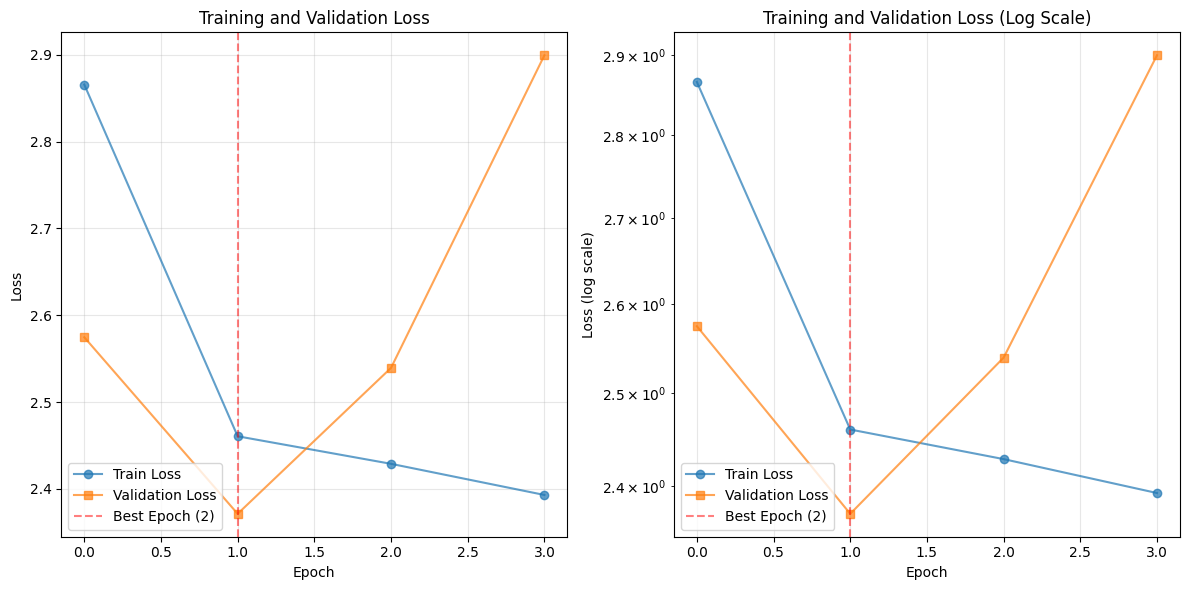


📊 Training Statistics:
   Total epochs: 4
   Best epoch: 2
   Best val loss: 2.371384
   Final train loss: 2.393071
   Final val loss: 2.899447

💾 Training history saved to: checkpoints/resnet_pose_20251208_120818/training_history.json
📈 Plot saved to: checkpoints/resnet_pose_20251208_120818/training_history.png


In [ ]:
# Save training history plot
import matplotlib.pyplot as plt
import json

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', marker='s', alpha=0.7)
plt.axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.yscale('log')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = os.path.join(run_dir, 'training_history.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Training Statistics:")
print(f"   Total epochs: {len(train_losses)}")
print(f"   Best epoch: {best_epoch}")
print(f"   Best val loss: {best_val_loss:.6f}")
print(f"   Final train loss: {train_losses[-1]:.6f}")
print(f"   Final val loss: {val_losses[-1]:.6f}")

# Save training history to JSON
history = {
    'train_losses': [float(x) for x in train_losses],
    'val_losses': [float(x) for x in val_losses],
    'best_epoch': int(best_epoch),
    'best_val_loss': float(best_val_loss),
    'total_epochs': len(train_losses),
    'timestamp': timestamp
}

history_path = os.path.join(run_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"\n💾 Training history saved to: {history_path}")
print(f"📈 Plot saved to: {plot_path}")


In [ ]:
path_to_module = f"/content/6D_pose/src"


import sys

sys.path.append(path_to_module)

In [ ]:
%pwd

'/content/6D_pose/src/pose_rgb'

In [ ]:
from model import ResNetQuaternion as RNQ

ImportError: cannot import name 'ResNetQuaternion' from 'model' (/content/6D_pose/src/pose_rgb/model.py)